In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from collections import defaultdict
from pathlib import Path

from src.consts import PATHS
from src.plots.info_flow_confidence import combine_confidence_plots, process_info_flow_files
from src.types import TokenType

In [3]:
models_data = {}

In [4]:
models_data.keys()

dict_keys([])

{'Falcon3-Mamba-7B-Base'} 24
dict_keys([(PosixPath('/home/yandex/DL20232024a/nirendy/repos/ssm_analysis/output/tiiuae/Falcon3-Mamba-7B-Base/info_flow_v7/ds=counter_fact/ws=1'), <TokenType.last: 'last'>), (PosixPath('/home/yandex/DL20232024a/nirendy/repos/ssm_analysis/output/tiiuae/Falcon3-Mamba-7B-Base/info_flow_v7/ds=counter_fact/ws=3'), <TokenType.last: 'last'>), (PosixPath('/home/yandex/DL20232024a/nirendy/repos/ssm_analysis/output/tiiuae/Falcon3-Mamba-7B-Base/info_flow_v7/ds=counter_fact/ws=5'), <TokenType.last: 'last'>), (PosixPath('/home/yandex/DL20232024a/nirendy/repos/ssm_analysis/output/tiiuae/Falcon3-Mamba-7B-Base/info_flow_v7/ds=counter_fact/ws=9'), <TokenType.last: 'last'>), (PosixPath('/home/yandex/DL20232024a/nirendy/repos/ssm_analysis/output/tiiuae/Falcon3-Mamba-7B-Base/info_flow_v7/ds=counter_fact/ws=12'), <TokenType.last: 'last'>), (PosixPath('/home/yandex/DL20232024a/nirendy/repos/ssm_analysis/output/tiiuae/Falcon3-Mamba-7B-Base/info_flow_v7/ds=counter_fact/ws=15'), <

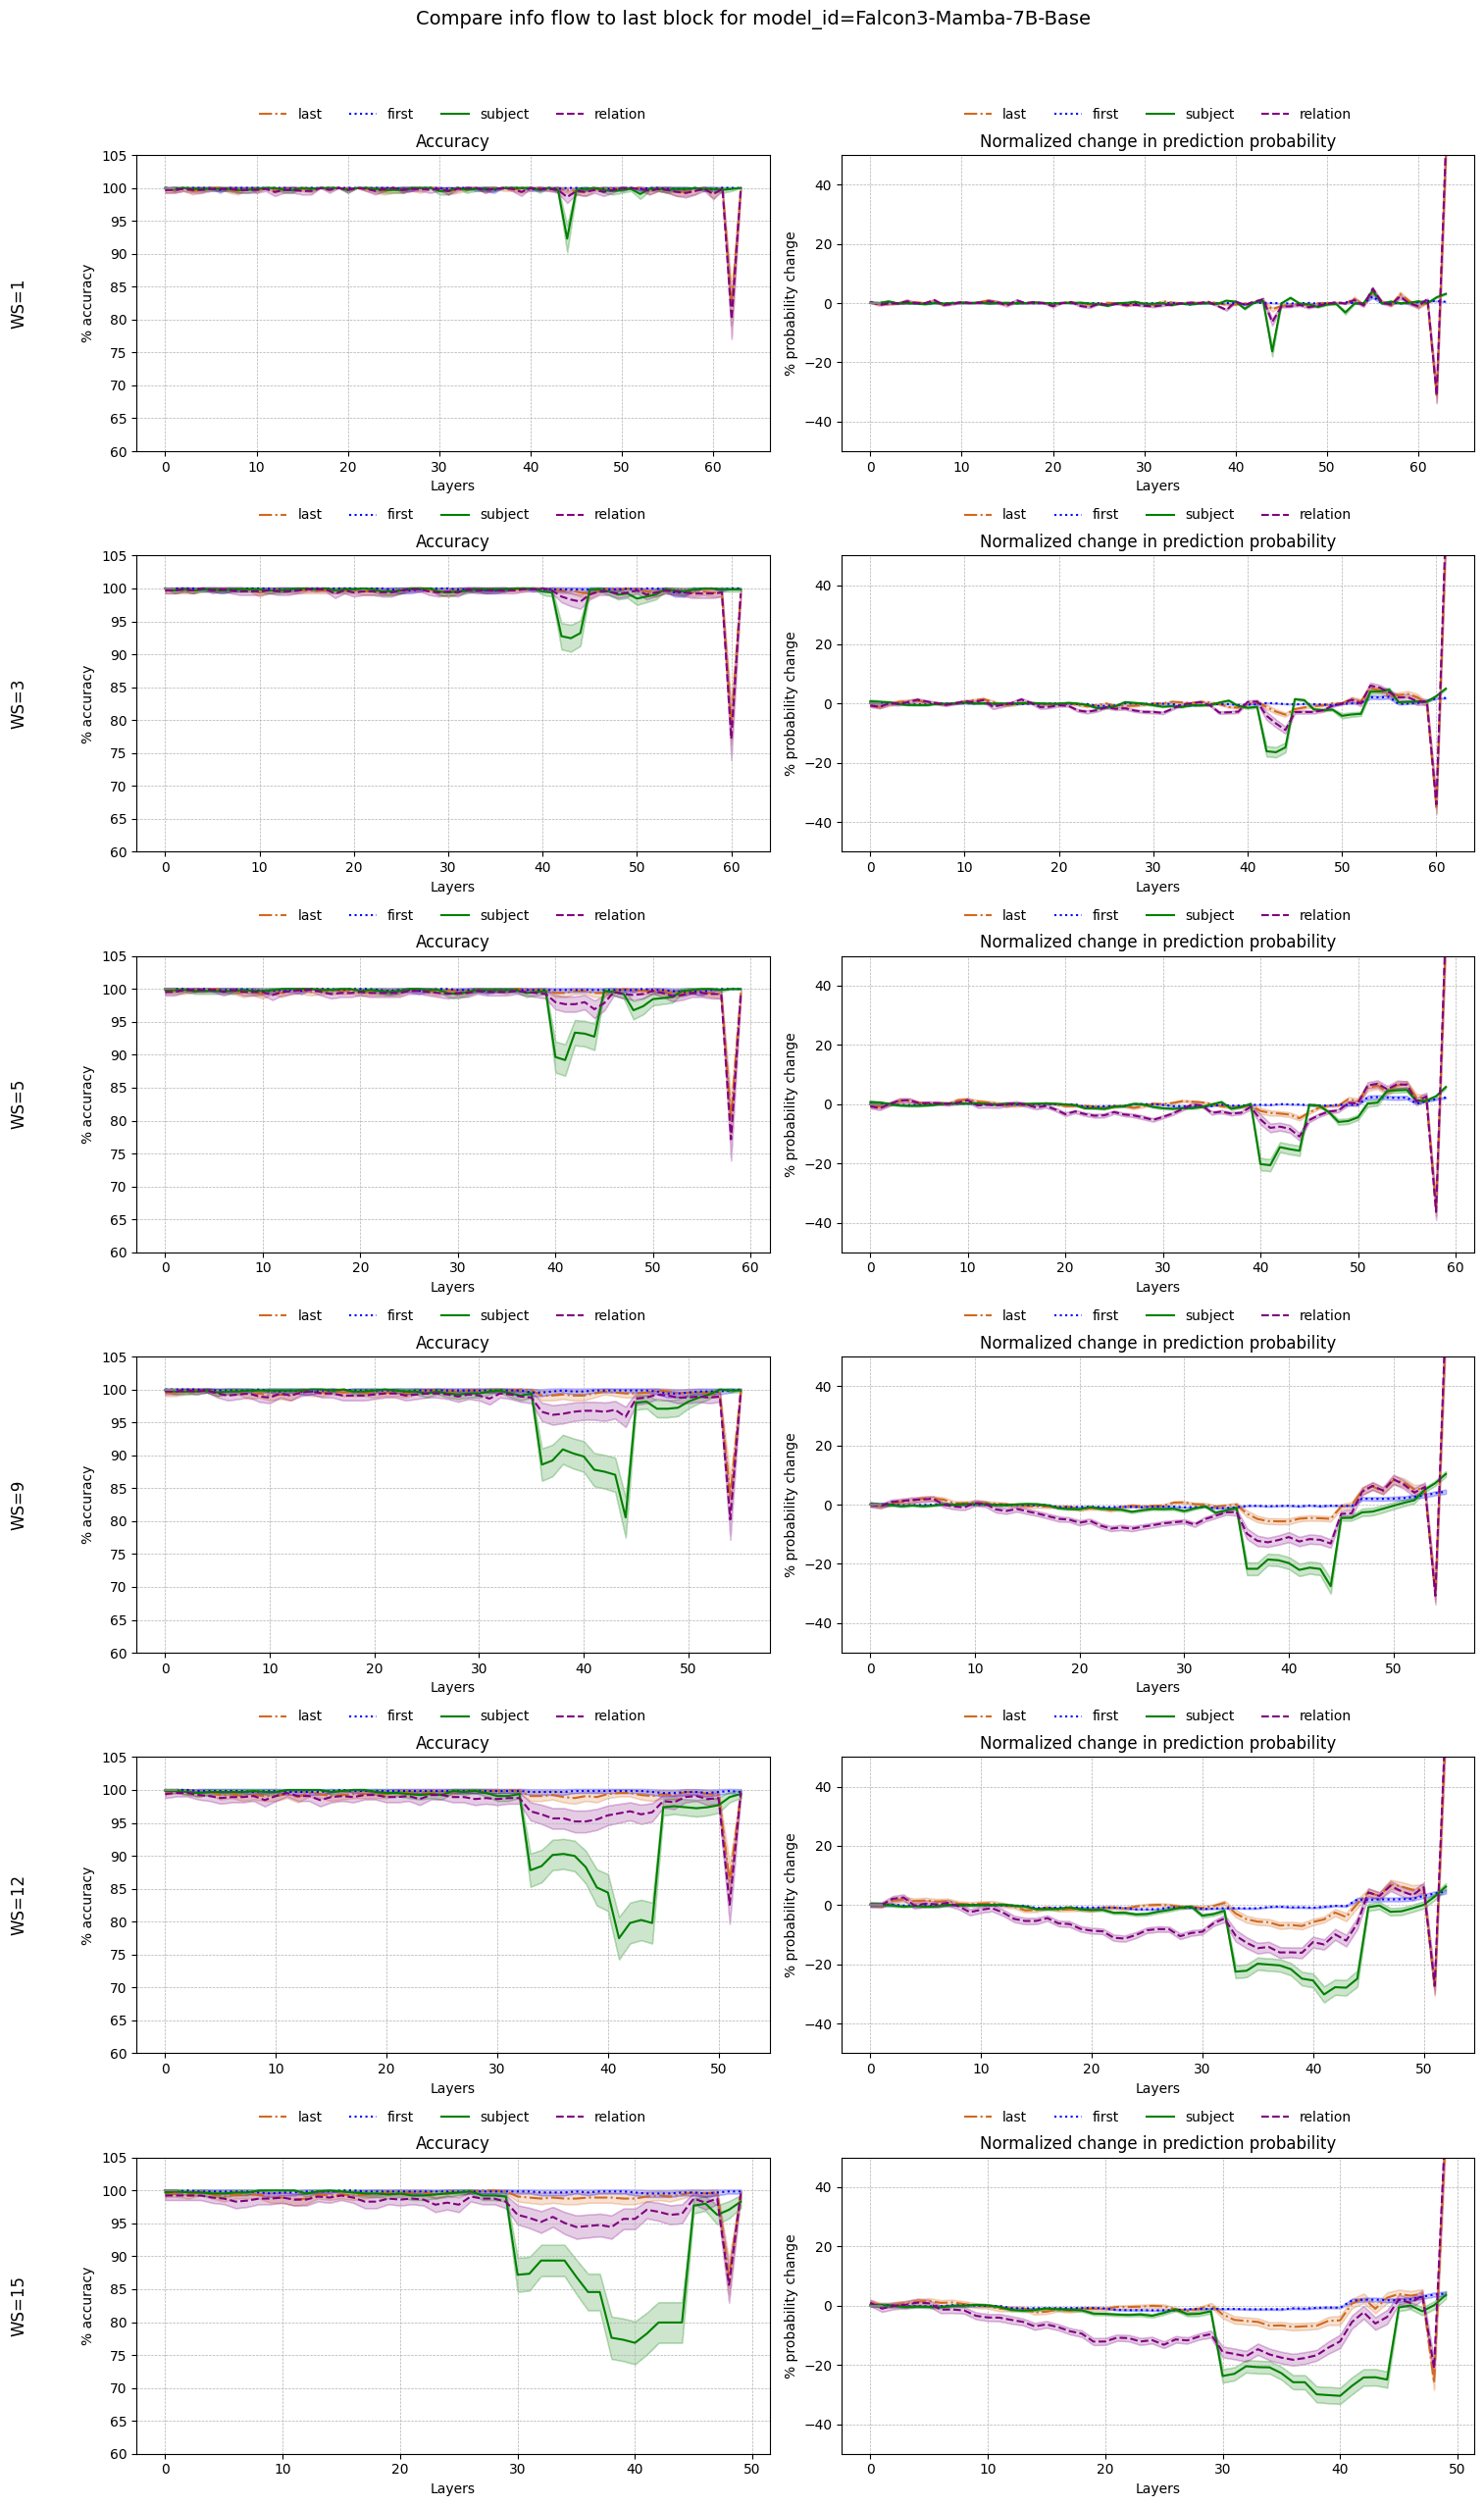

In [12]:
pattern = r"/(?P<arch_original>[\w\.-]+)/(?P<model_id>[\w\.-]+)/info_flow(?P<version>_v\d+)/ds=(?P<dataset>[\w_]+)/ws=(?P<window_size>\d+)/block_(?P<from_block>\w+)_target_(?P<to_block>\w+)/outputs.json"

candidate_files: list[tuple[Path, dict]] = []

for p in PATHS.OUTPUT_DIR.rglob("*.json"):
    match = re.search(pattern, str(p))
    if match:
        details = match.groupdict()
        # if details["version"] != "_v8":
        if details["version"] not in ["_v7"]:
            continue
            # if details["window_size"] != "15":
            continue
        if details["to_block"] != "last":
            continue
        # if details["model_id"] != "falcon-mamba-7b":
        # if details["model_id"] != "mamba-2.8B-hf":
        # if details["model_id"] != "mamba2-2.7B":
        # if details["model_id"] != 'mamba-7b-rw':
        if details["model_id"] != "Falcon3-Mamba-7B-Base":
            # if 'mamba2' in details["model_id"]:
            # if 'mamba2' not in details["model_id"]:
            continue
        candidate_files.append((p, details))

print(set(details["model_id"] for p, details in candidate_files), len(candidate_files))

candidate_plots: dict[tuple[Path, TokenType], dict[TokenType, tuple[dict, Path]]] = defaultdict(dict)

sort_by, fixed_by = "window_size", "model_id"
# sort_by, fixed_by = 'model_id', 'window_size'

if sort_by == "window_size":
    for candidate_file, details in sorted(candidate_files, key=lambda x: int(x[1]["window_size"])):
        candidate_plots[(candidate_file.parent.parent, TokenType(details["to_block"]))][
            TokenType(details["from_block"])
        ] = (details, candidate_file)
elif sort_by == "model_id":
    order = [
        "mamba-130M-hf",
        "mamba2-130M",
        "mamba-1.4B-hf",
        "mamba2-1.3b",
        "mamba-2.8B-hf",
        "mamba2-2.7B",
        "mamba-7b-rw",
        "falcon-mamba-7b",
        "Falcon3-Mamba-7B-Base",
    ]
    key_sort = lambda x: order.index(x)
    for candidate_file, details in sorted(candidate_files, key=lambda x: key_sort(x[1]["model_id"])):
        candidate_plots[(candidate_file.parent.parent, TokenType(details["to_block"]))][
            TokenType(details["from_block"])
        ] = (details, candidate_file)

print(candidate_plots.keys())

model_figs = {}
for i, (key, value) in enumerate(candidate_plots.items()):
    # if i != 3:
    #     continue
    details = value[list(value.keys())[0]][0]
    fig = process_info_flow_files(
        from_blocks=value,
        target_block=key[1],
        confidence_level=0.95,
        # confidence_level=0,
        save_fig=False,
        show_fig=False,
    )

    if sort_by == "window_size":
        model_figs[f"WS={details['window_size']}"] = fig
    elif sort_by == "model_id":
        model_figs[f"MS={details['model_id']}"] = fig
    # break

# Combine all plots into one figure
combined_fig = combine_confidence_plots(
    figs=model_figs,
    output_path=None,
    suptitle=f"Compare info flow to last block for {fixed_by}={details[fixed_by]}",
    figsize=(15, 25),
    show_fig=True,
)